In [1]:
import sys
sys.path.append("..")

from data_transformation.db_env import DbEnv, db

# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

https://www.kaggle.com/izzettunc/introduction-to-time-series-clustering

# 1.Preprocessing

In [2]:
#get song_num list
# 지수 추가해서 그래프에서 비교 가능하게 해주기, 클러스터링 기준?

conn, cursor = DbEnv().connect_sql()
sql = "SELECT DISTINCT num FROM daily_music_cow"
num_list = DbEnv().get_data_from_table(cursor, sql)
num_list = [item[0] for item in num_list]
print(num_list)

[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 167, 168, 169, 171, 173, 174, 175, 176, 177, 178, 179, 180, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199, 202, 204, 206, 207, 208, 211, 212, 216, 218, 219, 221, 224, 225, 230, 231, 233, 237, 238, 240, 258, 261, 262, 265, 267, 274, 311, 322, 345, 373, 382, 420, 460, 461, 462, 464, 465, 466, 467, 468, 469, 470, 471, 472, 474, 475, 477, 478, 479, 480, 481, 482, 483, 484, 485

In [3]:
df_price, df_mcpi = pd.DataFrame(), pd.DataFrame()

# find shortest date length to fit all songs
for num in num_list:
    sql = "SELECT date, price FROM daily_music_cow WHERE num = %s" % num
    df_temp = db(cursor, sql).dataframe
    df_temp = df_temp.set_index('date')
    df_temp.columns = ["%d" % num]

    df_price = pd.concat([df_price, df_temp], axis=1)

print(df_price)
df_price.to_pickle("../storage/df_price.pkl")

               26     27     28     29     30     31     32     33     34  \
date                                                                        
2021-06-03  29000  26000  24000  52800  13500  16100  10300  14500  36400   
2021-06-04  29000  26000  24000  52800  13500  16100  10300  14500  36400   
2021-06-05  29000  26000  23700  52800  13500  16100  10800  14500  36400   
2021-06-06  28500  26000  23500  52800  13500  16100  10800  14500  36400   
2021-06-07  29100  26000  24900  52800  13500  15100  10800  14500  36400   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2021-11-23  29000  43000  29800  90700  19100  70100  15100  37200  40000   
2021-11-24  28500  43000  29900  90700  19100  70000  15000  37200  40000   
2021-11-25  27900  43000  29800  90700  19100  70000  15000  37200  40000   
2021-11-26  30000  43000  31200  90700  19100  70000  15000  37200  40000   
2021-11-27  27000  43000  29100  90700  19000  70000  16100  37200  40000   

In [4]:
sql = "SELECT date, price FROM daily_mcpi"
df_mcpi = db(cursor, sql).dataframe
df_mcpi = df_mcpi.set_index('date')
df_mcpi.columns = [0]

print(df_mcpi)
df_mcpi.to_pickle("../storage/df_mcpi.pkl")

                 0
date              
2021-12-08  246.43
2021-12-07  247.01
2021-12-06  246.48
2021-12-05  246.18
2021-12-04  245.84
...            ...
2019-03-24   83.54
2019-03-23   83.59
2019-03-22   83.44
2019-03-21   82.88
2019-03-20   82.59

[995 rows x 1 columns]


In [5]:
# 결측치 제거를 통해 date 맞춰주기
df_price = pd.read_pickle('../storage/df_price.pkl')
df_mcpi = pd.read_pickle('../storage/df_mcpi.pkl')

df_price = pd.concat([df_mcpi, df_price], axis=1)

df_price_droped = df_price.dropna(axis=0)
df_price_droped = df_price_droped.sort_index(ascending=True)
list_price_droped = list(df_price_droped.columns)

print(df_price_droped)

                 0       26       27       28       29       30       31  \
date                                                                       
2021-07-06  189.31  24000.0  23000.0  19000.0  60500.0  12900.0  22000.0   
2021-07-07  189.07  24000.0  23000.0  19000.0  60500.0  12900.0  22000.0   
2021-07-08  187.87  24000.0  23000.0  19000.0  60500.0  12900.0  22000.0   
2021-07-09  187.28  23900.0  23000.0  17800.0  60500.0  12900.0  22000.0   
2021-07-10  187.98  23800.0  17000.0  16600.0  60500.0  12900.0  22000.0   
...            ...      ...      ...      ...      ...      ...      ...   
2021-11-23  247.03  29000.0  43000.0  29800.0  90700.0  19100.0  70100.0   
2021-11-24  246.02  28500.0  43000.0  29900.0  90700.0  19100.0  70000.0   
2021-11-25  245.77  27900.0  43000.0  29800.0  90700.0  19100.0  70000.0   
2021-11-26  242.78  30000.0  43000.0  31200.0  90700.0  19100.0  70000.0   
2021-11-27  243.98  27000.0  43000.0  29100.0  90700.0  19000.0  70000.0   

           

In [6]:
# MinMaxScaler로 정규화
array_price_scaled = MinMaxScaler().fit_transform(df_price_droped)
df_price_scaled = pd.DataFrame(array_price_scaled)
df_price_scaled.columns = list_price_droped
df_price_scaled.index = df_price_droped.index
print(df_price_scaled)

# num=0(MCPI) 지수 df에서 제거
df_mcpi = df_price_scaled[df_price_scaled.columns[0]]
df_price_scaled = df_price_scaled.drop(df_price_scaled.columns[0], axis='columns')

print(df_mcpi)

                   0        26        27        28        29        30  \
date                                                                     
2021-07-06  0.033448  0.018939  0.197015  0.067797  0.159490  0.063348   
2021-07-07  0.032253  0.018939  0.197015  0.067797  0.159490  0.063348   
2021-07-08  0.026280  0.018939  0.197015  0.067797  0.159490  0.063348   
2021-07-09  0.023344  0.015152  0.197015  0.033898  0.159490  0.063348   
2021-07-10  0.026828  0.011364  0.017910  0.000000  0.159490  0.063348   
...              ...       ...       ...       ...       ...       ...   
2021-11-23  0.320741  0.208333  0.794030  0.372881  0.400319  0.156863   
2021-11-24  0.315714  0.189394  0.794030  0.375706  0.400319  0.156863   
2021-11-25  0.314469  0.166667  0.794030  0.372881  0.400319  0.156863   
2021-11-26  0.299587  0.246212  0.794030  0.412429  0.400319  0.156863   
2021-11-27  0.305560  0.132576  0.794030  0.353107  0.400319  0.155354   

                  31        32       

# 2. Clustering

In [7]:
print(df_mcpi)

date
2021-07-06    0.033448
2021-07-07    0.032253
2021-07-08    0.026280
2021-07-09    0.023344
2021-07-10    0.026828
                ...   
2021-11-23    0.320741
2021-11-24    0.315714
2021-11-25    0.314469
2021-11-26    0.299587
2021-11-27    0.305560
Name: 0, Length: 145, dtype: float64


## (1) SOM

In [8]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(array_price_scaled))))


som = MiniSom(som_x, som_y,len(array_price_scaled[0]), sigma=0.3, learning_rate=0.1)

som.random_weights_init(array_price_scaled)
som.train(array_price_scaled, 50000)

In [9]:
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="green")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

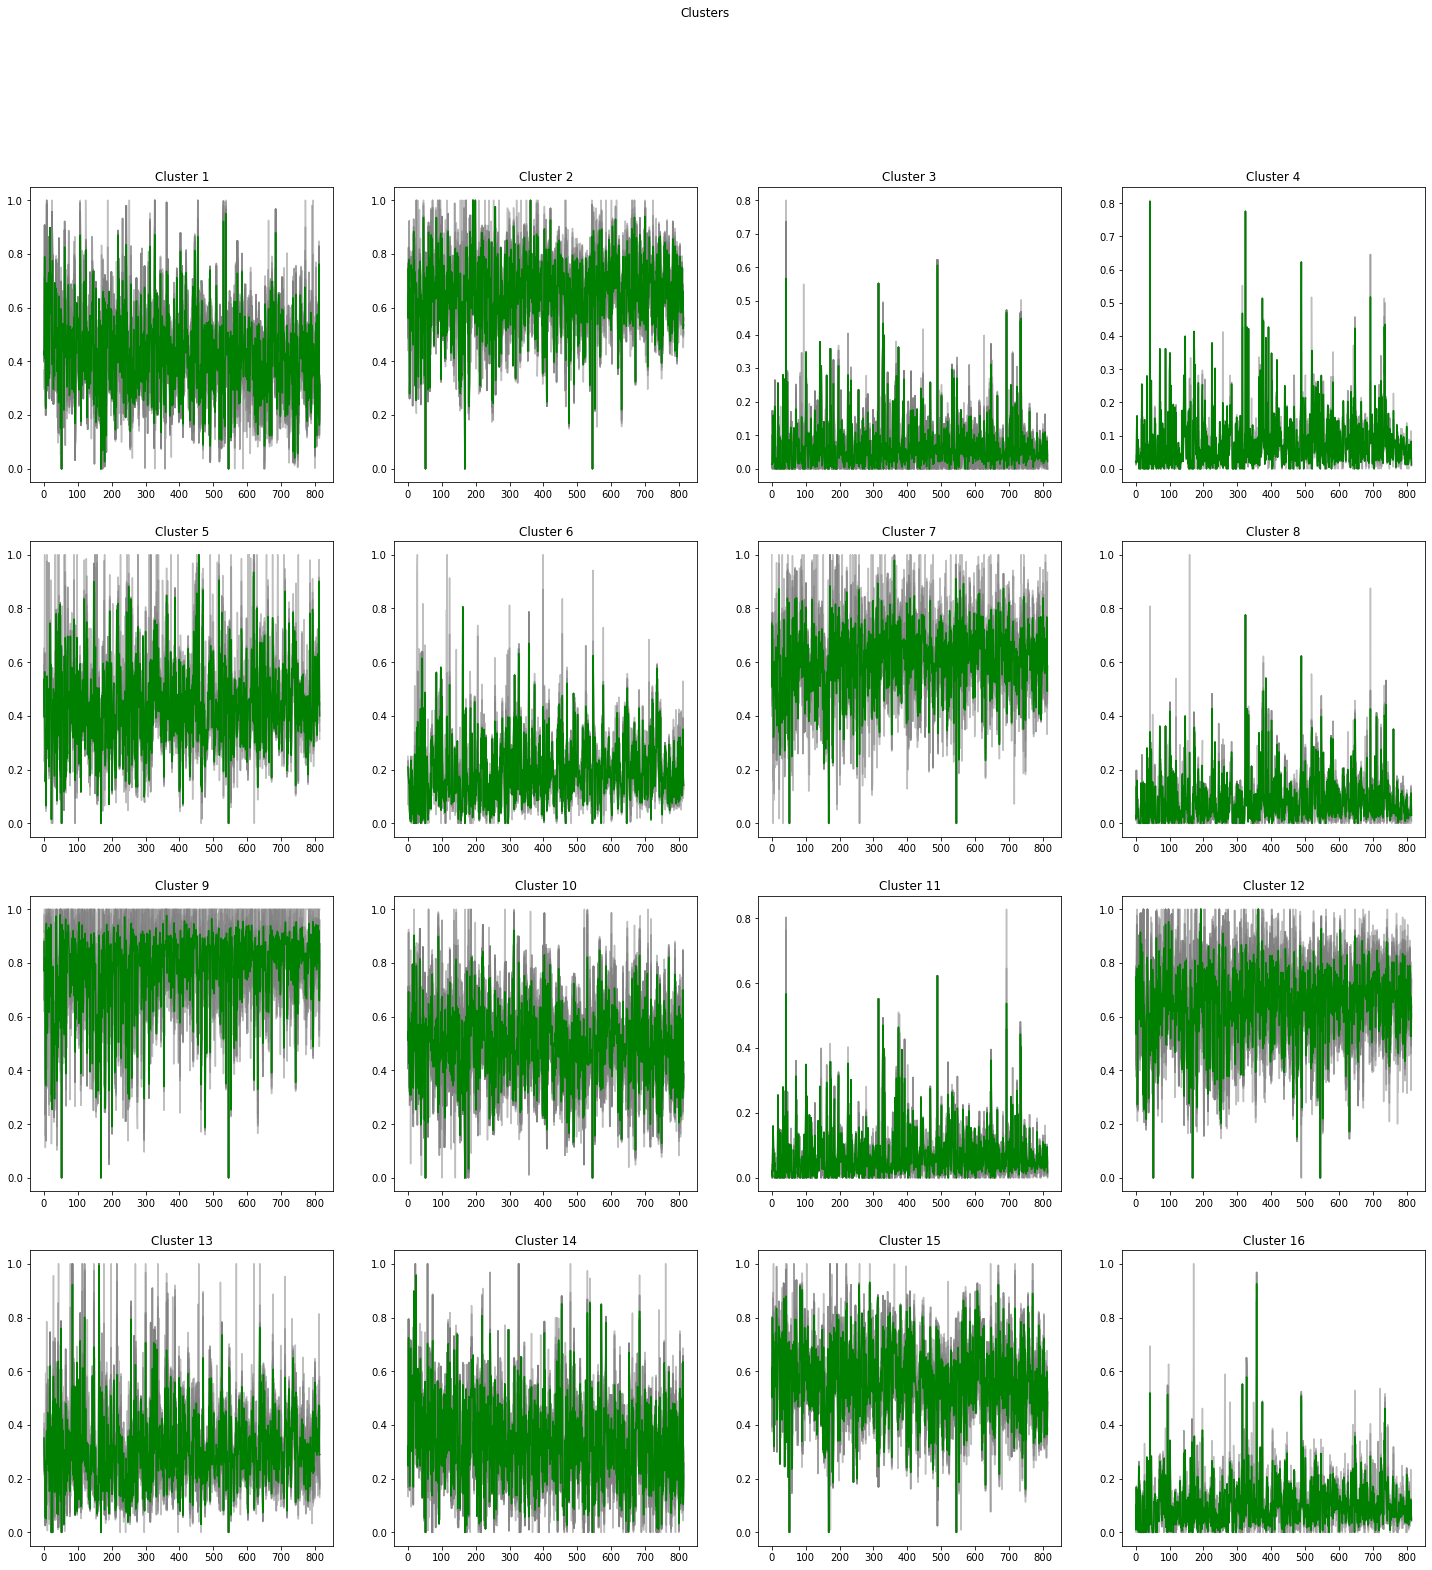

In [10]:
win_map = som.win_map(array_price_scaled)

plot_som_series_averaged_center(som_x, som_y, win_map)

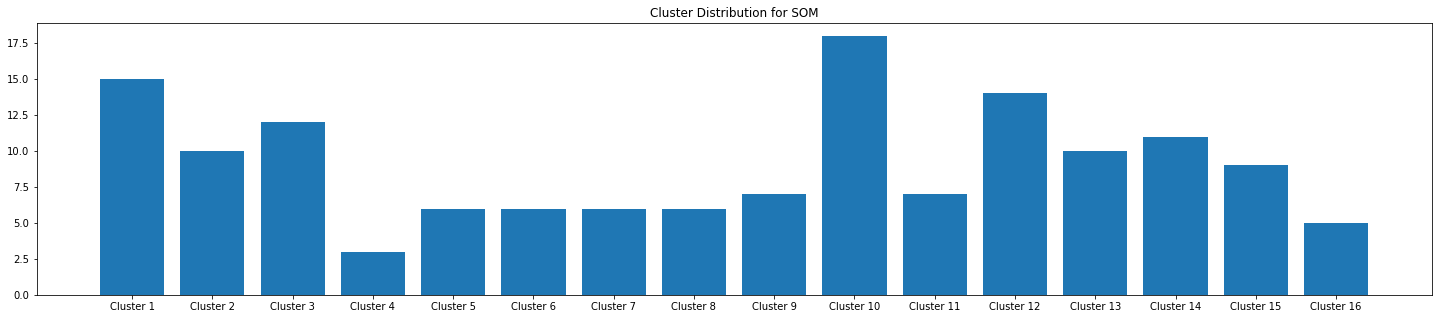

In [11]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

In [12]:
cluster_map = []
for idx in range(len(array_price_scaled)):
    winner_node = som.winner(array_price_scaled[idx])
    cluster_map.append((list_price_droped[idx],f"Cluster {winner_node[0]*som_y+winner_node[1]+1}"))

df_cluster = pd.DataFrame(cluster_map,columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

In [13]:
conn = DbEnv().connect_mongo('music_cow', 'daily_music_cow')

In [14]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 1"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['155', '153', '154', '149', '156', '157', '158', '159', '160', '161', '163', '164', '148', '151', '150']
title: 목소리 --- artist: 백지영
title: 똑 똑 똑 --- artist: 아이오아이
title: 팔베개 --- artist: 소유
title: So Good --- artist: 카라
title: 블랙홀 --- artist: MC몽
title: Good-night Kiss --- artist: 전효성
title: I'm In Love --- artist: 시크릿
title: 그래도 남자니까 --- artist: MC몽
title: 넌 너무 야해 --- artist: 씨스타
title: 천하무적 --- artist: MC몽
title: 권태중독 --- artist: MC몽
title: So Fresh --- artist: MC몽
title: If You Love Me --- artist: NS 윤지
title: 우리가 사는 이야기 --- artist: god
title: 홈런 --- artist: MC몽


In [15]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 2"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['115', '114', '112', '111', '110', '108', '107', '106', '104', '103']
title: 짧은머리 --- artist: 허각
title: 반창고 --- artist: 허각
title: 눈물 --- artist: 리쌍
title: 사랑 범벅 --- artist: MC몽
title: 미치겠어 --- artist: MC몽
title: 너에게 닿기를 --- artist: 우주소녀
title: TIAMO --- artist: 티아라
title: 별의 별 --- artist: Apink
title: Give It To Me --- artist: 씨스타
title: I Love U Oh Thank U --- artist: MC몽


In [16]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 3"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['45', '41', '42', '43', '52', '51', '48', '50', '49', '44', '47', '46']
title: Dream --- artist: 수지
title: 빨간 운동화 --- artist: 박혜경
title: 안녕 --- artist: 박혜경
title: 하이힐 --- artist: 박혜경
title: 바질 --- artist: 매드클라운
title: 화 --- artist: 매드클라운
title: 너와 함께 --- artist: 울랄라세션
title: Fly --- artist: SUPER JUNIOR-K.R.Y.
title: 기억할게요 --- artist: 양파
title: Yesterday --- artist: 박혜경
title: 가슴앓이 --- artist: 바비 킴
title: 서울사람들 --- artist: 버스커 버스커


In [17]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 4"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['31', '33', '32']
title: My Style --- artist: 조PD
title: Couple Song --- artist: 라디
title: 고마워고마워 --- artist: 라디


In [18]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 5"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['76', '74', '75', '77', '78', '79']
title: 살아서도.. 죽어서도.. --- artist: 휘성
title: 사랑이라 쓰고 아픔이라 부른다 --- artist: 서인영
title: 슬픈 발걸음 --- artist: 씨야
title: 별빛 바램 --- artist: SHINee
title: 두근두근 --- artist: 벤
title: 소주 한 잔 --- artist: 임창정


In [19]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 6"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['60', '59', '58', '62', '63', '61']
title: 다툼 --- artist: 제리케이
title: Femme Fatale --- artist: 스윙스
title: 둘만 아는 말투 --- artist: 제리케이
title: 예쁜 나이 25살 --- artist: 송지은
title: 기억에게 외치다 --- artist: 장우혁
title: 링마벨 --- artist: 걸스데이


In [20]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 7"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['116', '117', '118', '81', '119', '80']
title: 맘마미아 --- artist: 카라
title: 너나 잘해 --- artist: 에일리
title: 죽을 만큼 아파서 --- artist: MC몽
title: 오랜만이야 --- artist: 임창정
title: 다시 --- artist: 터보
title: 나와 같다면 --- artist: 김장훈


In [21]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 8"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['29', '30', '28', '27', '26', 0]
title: I Can't --- artist: 2PM
title: 오랜만이죠 --- artist: 라디
title: 엄마 --- artist: 라디
title: 연애시대 --- artist: 이승기
title: I'm in love --- artist: 라디


In [22]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 9"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['83', '84', '85', '86', '87', '82', '88']
title: 소원 --- artist: 김현성
title: 슬픔을 참는 세 가지 방법 --- artist: 혜령
title: Again --- artist: 스페이스 에이
title: 보란듯이 --- artist: 손승연
title: 이름 --- artist: 임재범
title: 나를 잊지 말아요 --- artist: 허각
title: 낡은 그리움 --- artist: 에일리


In [23]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 10"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['147', '144', '142', '141', '129', '130', '131', '132', '133', '134', '135', '136', '137', '145', '146', '143', '139', '140']
title: 처음 느껴본 이별 --- artist: 정은지
title: Lay Back --- artist: 케이윌
title: 하지마 --- artist: B.A.P
title: 바다를 나는 거북이 --- artist: 정세운
title: 미운오리새끼 --- artist: god
title: 전쟁이야 --- artist: 엠블랙
title: Good Morning Baby --- artist: Apink
title: 웃픈 하루 --- artist: god
title: 사람냄새 --- artist: 정인
title: Bubble Love --- artist: 서인영
title: 나도 여자예요 --- artist: 민아
title: 러브119 --- artist: 케이윌
title: 동네술집 --- artist: 허각
title: Pepe --- artist: CLC
title: 아무도 모르게 --- artist: 치타
title: 마음 단단히 먹어 --- artist: MC몽
title: 촌스럽게 왜 이래 --- artist: 케이윌
title: 잠꼬대 --- artist: 뉴이스트


In [24]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 11"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['35', '36', '34', '38', '39', '40', '37']
title: 너와 함께 있음을 --- artist: 라디
title: Goodbye --- artist: 라디
title: 어머니의 된장국 --- artist: 다이나믹 듀오
title: 어떤 설레임 --- artist: 라디
title: 아버지 --- artist: 다이나믹 듀오
title: 난 네게 --- artist: 라디
title: Happy Birthday --- artist: 라디


In [25]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 12"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['101', '102', '99', '89', '90', '91', '92', '93', '94', '95', '100', '97', '98', '96']
title: 내 생애 가장 행복한 시간 --- artist: MC몽
title: 너에게 쓰는 편지 --- artist: MC몽
title: Something --- artist: 걸스데이
title: Paradise --- artist: 효린
title: HONEY BEE --- artist: 루나
title: 하늘바라기 --- artist: 정은지
title: Mr. Chu --- artist: Apink
title: 널 너무 사랑해서 --- artist: MC몽
title: 너란 봄 --- artist: 정은지
title: Darling --- artist: 걸스데이
title: I Need You --- artist: 허각
title: 거북이 --- artist: 다비치
title: 서커스 --- artist: MC몽
title: Loving U --- artist: 씨스타


In [26]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 13"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['73', '64', '65', '66', '72', '68', '69', '70', '71', '67']
title: 저녁하늘 --- artist: 에일리
title: 심상치 않아 --- artist: 키썸
title: 이상하다 참 --- artist: 민아
title: 예쁘다 --- artist: 에어플레인
title: 사고쳤어요 --- artist: 다비치
title: White Day --- artist: 걸스데이
title: 너만 봐 --- artist: 유지
title: If You --- artist: 에일리
title: 그 중에 그대를 만나 --- artist: 이선희
title: 1분 1초 --- artist: 지연


In [27]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 14"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['167', '168', '169', '171', '173', '174', '175', '176', '165', '178', '177']
title: Good Good Time --- artist: 코요태
title: IF... --- artist: B1A4
title: 오늘 밤 --- artist: 린
title: 동화 같은 사랑 --- artist: Apink
title: Luv D.N.A --- artist: MC몽
title: 너를 원해 --- artist: 정기고
title: 마지막 그 한마디 --- artist: 이승기
title: 죽을만큼 아파서 Part.2 --- artist: MC몽
title: New York --- artist: MC몽
title: Simple Love --- artist: MC몽
title: 호러쇼 --- artist: MC몽


In [28]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 15"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['121', '128', '127', '126', '125', '124', '123', '122', '120']
title: Indian Boy --- artist: MC몽
title: 아이스크림 --- artist: MC몽
title: 도망가자 --- artist: MC몽
title: 못된 여자 --- artist: 원투
title: 죽도록 사랑해 --- artist: MC몽
title: 하늘색 약속 --- artist: god
title: Beautiful Target --- artist: B1A4
title: 부산 바캉스 --- artist: 레게 강 같은 평화
title: 대박사건 --- artist: B.A.P


In [29]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 16"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['55', '54', '53', '56', '57']
title: Tic Toc --- artist: 매드클라운
title: Rap Star --- artist: 스윙스
title: 때려박는 랩 --- artist: 매드클라운
title: Would You Be My --- artist: 팔로알토
title: 꽃 --- artist: 매드클라운


## 2. Dynamic Time Warping Barycenter Averaging (DBA)

In [32]:
import random
from copy import deepcopy
from scipy import interpolate
import numpy as np
from dtaidistance import dtw
import matplotlib.pyplot as plt
from _plotly_future_ import v4_subplots
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [33]:
NUM_OF_TRAJECTORIES = 200
MIN_LEN_OF_TRAJECTORY = 16
MAX_LEN_OF_TRAJECTORY = 40
THRESHOLD = 0.50

In [ ]:
array_price_scaled = deepcopy(array_price_scaled)
distanceMatrixDictionary = {}
iteration = 1
while True:
   distanceMatrix = np.empty((len(array_price_scaled), len(array_price_scaled),))
   distanceMatrix[:] = np.nan
   
   for index1, (filter1, trajectory1) in enumerate(trajectories.items()):
      tempArray = []
      
      for index2, (filter2, trajectory2) in enumerate(trajectories.items()):
         
         if index1 > index2:
            continue
         
         elif index1 == index2:
            continue
         
         else:
            unionFilter = filter1 + filter2
            sorted(unionFilter)
            
            if unionFilter in distanceMatrixDictionary.keys():
               distanceMatrix[index1][index2] = distanceMatrixDictionary.get(unionFilter)
               
               continue
            
            metric = []
            for subItem1 in trajectory1:
               
               for subItem2 in trajectory2:
                  metric.append(dtw.distance(subItem1, subItem2, psi=1))
            
            metric = max(metric)
            
            distanceMatrix[index1][index2] = metric
            distanceMatrixDictionary[unionFilter] = metric